Problem 1

Using device: cuda

Training ViT - dim: 256, heads: 2
[01] Train Acc: 3.66%, Val Acc: 4.50%
[02] Train Acc: 4.28%, Val Acc: 5.00%
[03] Train Acc: 5.12%, Val Acc: 5.00%
[04] Train Acc: 6.30%, Val Acc: 4.40%
[05] Train Acc: 7.64%, Val Acc: 9.50%
[06] Train Acc: 7.82%, Val Acc: 8.80%
[07] Train Acc: 9.22%, Val Acc: 9.20%
[08] Train Acc: 10.42%, Val Acc: 10.90%
[09] Train Acc: 11.06%, Val Acc: 11.50%
[10] Train Acc: 11.66%, Val Acc: 9.90%
[11] Train Acc: 12.34%, Val Acc: 12.30%
[12] Train Acc: 13.70%, Val Acc: 11.00%
[13] Train Acc: 13.44%, Val Acc: 12.20%
[14] Train Acc: 14.36%, Val Acc: 15.40%
[15] Train Acc: 15.74%, Val Acc: 14.20%
[16] Train Acc: 15.82%, Val Acc: 14.50%
[17] Train Acc: 16.98%, Val Acc: 14.90%
[18] Train Acc: 18.70%, Val Acc: 16.20%
[19] Train Acc: 18.68%, Val Acc: 15.60%
[20] Train Acc: 20.04%, Val Acc: 17.30%

Training ViT - dim: 256, heads: 4
[01] Train Acc: 3.12%, Val Acc: 4.60%
[02] Train Acc: 4.00%, Val Acc: 2.70%
[03] Train Acc: 5.58%, Val Acc: 5.80%
[04] Train A

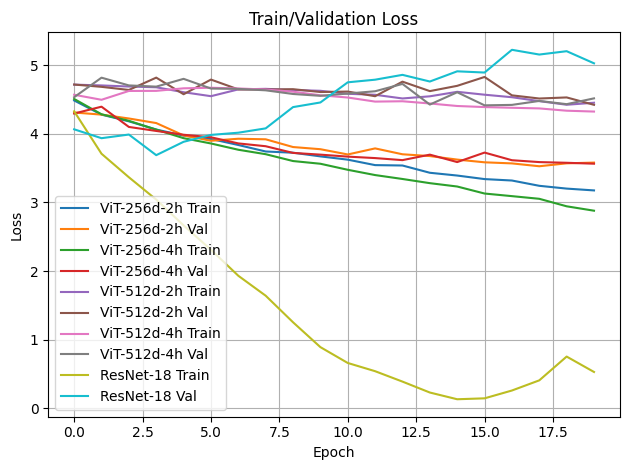

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import time

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

np.random.seed(42)
train_subset = Subset(train_data, np.random.choice(len(train_data), 5000, replace=False))
test_subset = Subset(test_data, np.random.choice(len(test_data), 1000, replace=False))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# ViT Components
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, mlp_hidden_dim, dropout=0.3):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x + self.attn(x, x, x)[0])
        x = self.norm2(x + self.mlp(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, depth, heads, mlp_hidden_dim, num_classes=100, dropout=0.3):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, embed_dim)
        num_patches = (32 // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim, heads, mlp_hidden_dim, dropout) for _ in range(depth)])
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        return self.head(x[:, 0])

# Training
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001, weight_decay=5e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    start = time.time()

    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            total += y.size(0)
            correct += out.argmax(1).eq(y).sum().item()
        history["train_loss"].append(loss_sum / len(train_loader))
        history["train_acc"].append(100 * correct / total)

        # Validation
        model.eval()
        total, correct, loss_sum = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_sum += criterion(out, y).item()
                total += y.size(0)
                correct += out.argmax(1).eq(y).sum().item()
        history["val_loss"].append(loss_sum / len(val_loader))
        history["val_acc"].append(100 * correct / total)

        print(f"[{epoch+1:02d}] Train Acc: {history['train_acc'][-1]:.2f}%, Val Acc: {history['val_acc'][-1]:.2f}%")

    history["total_time"] = time.time() - start
    return history

# FLOP Estimator
def estimate_flops(embed_dim, heads, layers, seq_len):
    return round((4 * embed_dim * seq_len**2 + 2 * seq_len * embed_dim**2) * layers / 1e6, 2)

# Model runs
configs = [
    {"embed_dim": 256, "heads": 2},
    {"embed_dim": 256, "heads": 4},
    {"embed_dim": 512, "heads": 2},
    {"embed_dim": 512, "heads": 4},
]

results = []
for cfg in configs:
    print(f"\nTraining ViT - dim: {cfg['embed_dim']}, heads: {cfg['heads']}")
    model = VisionTransformer(
        patch_size=4, embed_dim=cfg['embed_dim'], depth=4,
        heads=cfg['heads'], mlp_hidden_dim=cfg['embed_dim']*2
    )
    hist = train_model(model, train_loader, test_loader)
    flops = estimate_flops(cfg['embed_dim'], cfg['heads'], 4, (32 // 4)**2 + 1)
    params = sum(p.numel() for p in model.parameters())
    results.append({
        "Model": f"ViT-{cfg['embed_dim']}d-{cfg['heads']}h",
        "Params": params,
        "FLOPs (M)": flops,
        "Final Acc": round(hist["val_acc"][-1], 2),
        "Time (s)": round(hist["total_time"], 2),
        "History": hist
    })

# ResNet-18
print("\nTraining ResNet-18")
resnet = resnet18(num_classes=100)
hist = train_model(resnet, train_loader, test_loader)
resnet_params = sum(p.numel() for p in resnet.parameters())
results.append({
    "Model": "ResNet-18",
    "Params": resnet_params,
    "FLOPs (M)": 556,
    "Final Acc": round(hist["val_acc"][-1], 2),
    "Time (s)": round(hist["total_time"], 2),
    "History": hist
})

# Summary Table
print("\n" + "="*65)
print(f"{'Model':<15} | {'Params':>10} | {'FLOPs (M)':>10} | {'Final Acc (%)':>14} | {'Time (s)':>10}")
print("-"*65)
for r in results:
    print(f"{r['Model']:<15} | {r['Params']:>10,} | {r['FLOPs (M)']:>10} | {r['Final Acc']:>14.2f} | {r['Time (s)']:>10}")
print("="*65)

# Plot loss
for r in results:
    plt.plot(r["History"]["train_loss"], label=f"{r['Model']} Train")
    plt.plot(r["History"]["val_loss"], label=f"{r['Model']} Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Problem 2

Using device: cuda

Fine-tuning Swin-Tiny (frozen backbone)...
[01] Train Acc: 1.42%, Val Acc: 2.30%
[02] Train Acc: 2.36%, Val Acc: 4.30%
[03] Train Acc: 4.32%, Val Acc: 7.60%
[04] Train Acc: 7.34%, Val Acc: 11.60%
[05] Train Acc: 11.76%, Val Acc: 15.20%

Fine-tuning Swin-Small (frozen backbone)...
[01] Train Acc: 1.80%, Val Acc: 2.80%
[02] Train Acc: 4.06%, Val Acc: 5.10%
[03] Train Acc: 7.16%, Val Acc: 8.80%
[04] Train Acc: 11.60%, Val Acc: 14.40%
[05] Train Acc: 16.60%, Val Acc: 19.40%

Training Swin-Tiny from scratch...
Training Swin-Tiny from scratch...
[01] Train Acc: 3.68%, Val Acc: 4.10%
[02] Train Acc: 5.60%, Val Acc: 7.20%
[03] Train Acc: 6.72%, Val Acc: 6.70%
[04] Train Acc: 8.62%, Val Acc: 8.20%
[05] Train Acc: 10.44%, Val Acc: 10.70%


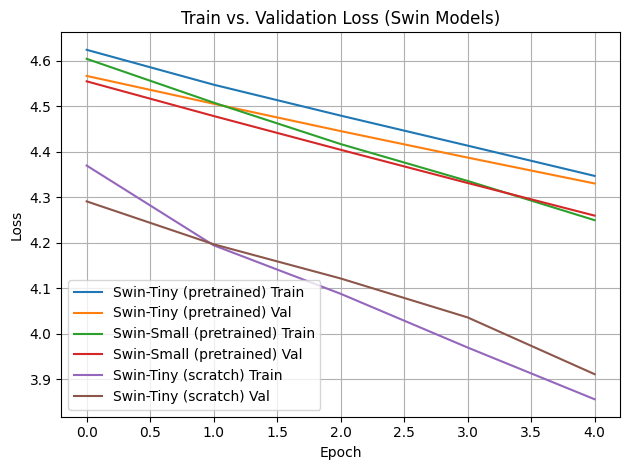


Model                     |  Trainable |      Total |  Val Acc |   Time (s)
----------------------------------------------------------------------
Swin-Tiny (pretrained)    |     76,900 | 27,596,254 |    15.20 |     140.19
Swin-Small (pretrained)   |     76,900 | 48,914,158 |    19.40 |     195.87
Swin-Tiny (scratch)       | 27,596,254 | 27,596,254 |    10.70 |     267.72


In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from transformers import SwinForImageClassification, SwinConfig
import time
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data (resize to 224x224 for Swin)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Use subset for quick training
np.random.seed(37)
train_subset = Subset(train_data, np.random.choice(len(train_data), 5000, replace=False))
test_subset = Subset(test_data, np.random.choice(len(test_data), 1000, replace=False))
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Training loop
def train_model(model, train_loader, val_loader, epochs=5, lr=2e-5, freeze_backbone=False):
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "classifier" not in name:
                param.requires_grad = False
    model.to(device)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    start = time.time()

    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).logits
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            total += y.size(0)
            correct += out.argmax(1).eq(y).sum().item()
        history["train_loss"].append(loss_sum / len(train_loader))
        history["train_acc"].append(100 * correct / total)

        # Validation
        model.eval()
        total, correct, loss_sum = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x).logits
                loss_sum += criterion(out, y).item()
                total += y.size(0)
                correct += out.argmax(1).eq(y).sum().item()
        history["val_loss"].append(loss_sum / len(val_loader))
        history["val_acc"].append(100 * correct / total)

        print(f"[{epoch+1:02d}] Train Acc: {history['train_acc'][-1]:.2f}%, Val Acc: {history['val_acc'][-1]:.2f}%")

    history["total_time"] = time.time() - start
    return history

# Run pretrained Swin-Tiny
swin_tiny = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swin_tiny.classifier = nn.Linear(swin_tiny.classifier.in_features, 100)
print("\nFine-tuning Swin-Tiny (frozen backbone)...")
tiny_result = train_model(swin_tiny, train_loader, test_loader, freeze_backbone=True)

# Run pretrained Swin-Small
swin_small = SwinForImageClassification.from_pretrained("microsoft/swin-small-patch4-window7-224")
swin_small.classifier = nn.Linear(swin_small.classifier.in_features, 100)
print("\nFine-tuning Swin-Small (frozen backbone)...")
small_result = train_model(swin_small, train_loader, test_loader, freeze_backbone=True)

# Train Swin-Tiny from scratch
config = SwinConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
config.num_labels = 100
scratch_model = SwinForImageClassification(config)
print("Training Swin-Tiny from scratch...")
scratch_result = train_model(scratch_model, train_loader, test_loader, freeze_backbone=False)

# Collect results
results = []
for name, model, res in zip(
    ["Swin-Tiny (pretrained)", "Swin-Small (pretrained)", "Swin-Tiny (scratch)"],
    [swin_tiny, swin_small, scratch_model],
    [tiny_result, small_result, scratch_result]
):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    results.append({
        "Model": name,
        "Trainable Params": trainable_params,
        "Total Params": total_params,
        "Final Val Acc (%)": round(res["val_acc"][-1], 2),
        "Training Time (s)": round(res["total_time"], 2),
        "History": res
    })

# Plot loss curves
for r in results:
    plt.plot(r["History"]["train_loss"], label=f"{r['Model']} Train")
    plt.plot(r["History"]["val_loss"], label=f"{r['Model']} Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss (Swin Models)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print final table
print("\n" + "="*70)
print(f"{'Model':<25} | {'Trainable':>10} | {'Total':>10} | {'Val Acc':>8} | {'Time (s)':>10}")
print("-"*70)
for r in results:
    print(f"{r['Model']:<25} | {r['Trainable Params']:>10,} | {r['Total Params']:>10,} | "
          f"{r['Final Val Acc (%)']:>8.2f} | {r['Training Time (s)']:>10}")
print("="*70)
